### Comparison of results for electronics 
Baselines
1. Association Analysis (baseline; cannot work with completely unsee pairs)
2. MF (binary, baseline; 43.1 minutes)
3. MF-bias (binary, baseline; 44.9 minutes)  
4. MF (Continuous, baseline; 44.27 minutes) 
5. MF-bias (Continuous, baseline; 43.7 minutes)  

Sequence-based
6. Node2Vec (Memory error)
7. Gensim word2vec (2.58 minutes)
8. PyTorch word2vec (23.63 minutes)
9. PyTorch word2vec with side information (107.66 minutes)
10. PyTorch MF (68.5 minutes)
11. PyTorch MF-bias (70.39 minutes)

### Comparison of results for books
Baselines
1. Association Analysis
2. MF (baseline)
3. MF-bias (baseline)  

Sequence-based
4. ~~Node2Vec~~
5. Gensim word2vec
6. PyTorch word2vec
7. ~~PyTorch word2vec with side information~~ (since it doesn't work)
8. PyTorch MF
9. PyTorch MF-bias

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from collections import OrderedDict

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics import recall_score, precision_score, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import torch

from src.ml.skipgram import SkipGram
from src.ml.mf import MF
from src.ml.mf_bias import MFBias
from src.ml.mf_continuous import MFContinuous
from src.ml.mf_bias_continuous import MFBiasContinuous
from src.viz.prep_results import get_product_id
from src.viz.plot_results import plot_auc, plot_roc, plot_tradeoff, plot_metrics
from src.utils.io_utils import load_model
from src.utils.logger import logger

In [3]:
dset = 'elec'

### Import validation data

In [4]:
val = pd.read_csv('../results/{}_edges_val.csv'.format(dset+'tronics'))

In [5]:
val.rename(columns={'weight': 'edge'}, inplace=True)

In [6]:
val.head()

,product1,product2,edge
0,b0002xhbys,b000mx5xpm,1
1,b000hdjt4s,b00glzuxnc,1
2,b0026k9l3o,b00855b5qa,1
3,b00009wc1t,b003fxkxk6,1
4,b004rxkwi6,b0089syu9c,1


In [7]:
val['edge'].value_counts()

1    1321736
0    1321736
Name: edge, dtype: int64

In [8]:
val['products'] = list(zip(val['product1'], val['product2']))

### 1. Association

In [9]:
assoc = load_model('../results/assoc_dict_{}'.format(dset))

2019-12-19 16:35:09,396 - Model loaded from: ../results/assoc_dict_elec (Size: 519027916 bytes)


In [10]:
val.head()

,product1,product2,edge,products
0,b0002xhbys,b000mx5xpm,1,"(b0002xhbys, b000mx5xpm)"
1,b000hdjt4s,b00glzuxnc,1,"(b000hdjt4s, b00glzuxnc)"
2,b0026k9l3o,b00855b5qa,1,"(b0026k9l3o, b00855b5qa)"
3,b00009wc1t,b003fxkxk6,1,"(b00009wc1t, b003fxkxk6)"
4,b004rxkwi6,b0089syu9c,1,"(b004rxkwi6, b0089syu9c)"


In [11]:
def get_assoc_score_func(assoc):
    def get_assoc_score(product1, product2):
        try:
            product_assoc = assoc[product1]
            return product_assoc[product2]
        except KeyError:
            return -1
        
    return get_assoc_score

func = get_assoc_score_func(assoc)
assoc_func = np.vectorize(func)

In [12]:
val['assoc_score'] = assoc_func(val['product1'], val['product2'])

In [13]:
val['assoc_score'].describe()

count    2643472.0
mean          -1.0
std            0.0
min           -1.0
25%           -1.0
50%           -1.0
75%           -1.0
max           -1.0
Name: assoc_score, dtype: float64

### 2. MF (binary, baseline; 43.1 minutes)

In [14]:
word2id_edge_mf = load_model('../results/word2id_edge_torch_mf_{}'.format(dset))
func = get_product_id(word2id_edge_mf)
word2id_func = np.vectorize(func)

2019-12-19 16:35:14,344 - Model loaded from: ../results/word2id_edge_torch_mf_elec (Size: 57402775 bytes)


In [15]:
mf = MF(len(word2id_edge_mf), 128)
mf.load_state_dict(torch.load('../results/mf_edges_epoch_4_2019-12-12-1035.pt', map_location=torch.device('cpu')))

2019-12-19 16:35:14,715 - Model initialized: MF(
  (embedding): Embedding(418749, 128)
  (sig): Sigmoid()
  (bce): BCELoss()
)


<All keys matched successfully>

In [16]:
val['product1id_mf_edge'] = word2id_func(val['product1'].values)
val['product2id_mf_edge'] = word2id_func(val['product2'].values)

In [17]:
product1 = torch.LongTensor(val['product1id_mf_edge'])
product2 = torch.LongTensor(val['product2id_mf_edge'])
with torch.no_grad():
    val['mf_score'] = mf.forward(product1, product2)

In [18]:
roc_score = roc_auc_score(val['edge'], val['mf_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-19 16:35:25,011 - AUC-ROC: 0.8082927619519629


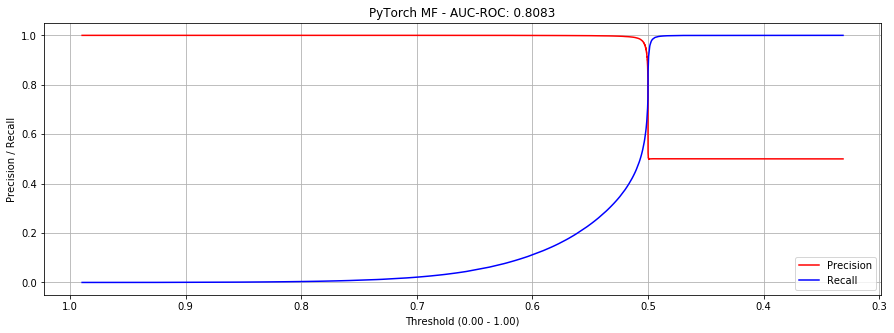

In [19]:
plot_auc(val['edge'], val['mf_score'], 'PyTorch MF - AUC-ROC: {:.4f}'.format(roc_score))

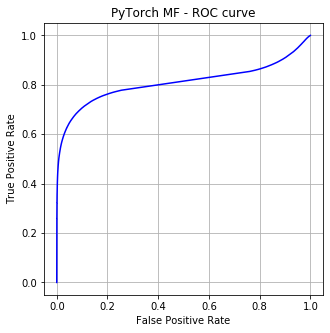

In [20]:
plot_roc(val['edge'], val['mf_score'], 'PyTorch MF - ROC curve')

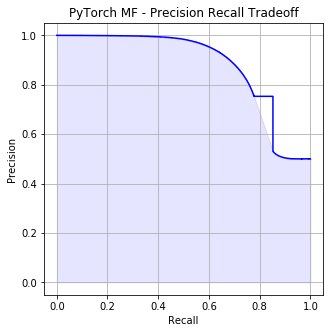

In [21]:
plot_tradeoff(val['edge'], val['mf_score'], 'PyTorch MF - Precision Recall Tradeoff')

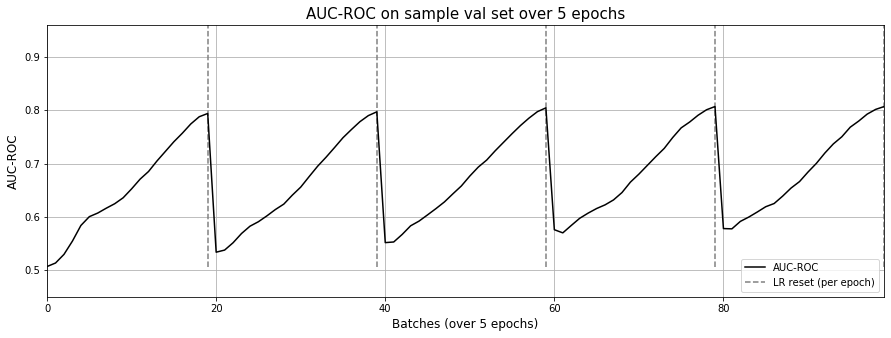

In [22]:
# Import and plot metrics
mf_edge_df = pd.read_csv('../results/model_metrics_mf_edges_elec.csv')
plot_metrics(mf_edge_df, ylim=(0.45, 0.96))

### 3. MF-bias (binary, baseline)

In [23]:
word2id_edge_mf_bias = load_model('../results/word2id_edge_torch_mf_bias_{}'.format(dset))
func = get_product_id(word2id_edge_mf_bias)
word2id_func = np.vectorize(func)

2019-12-19 16:35:29,992 - Model loaded from: ../results/word2id_edge_torch_mf_bias_elec (Size: 57402775 bytes)


In [24]:
mf = MFBias(len(word2id_edge_mf_bias), 128)
mf.load_state_dict(torch.load('../results/mf_bias_edges_epoch_4_2019-12-13-0232.pt', map_location=torch.device('cpu')))

2019-12-19 16:35:30,393 - Model initialized: MFBias(
  (product_embedding): Embedding(418749, 128)
  (sig): Sigmoid()
  (product_bias): Embedding(418749, 1)
  (bce): BCELoss()
)


<All keys matched successfully>

In [25]:
val['product1id_mf_bias_edge'] = word2id_func(val['product1'].values)
val['product2id_mf_bias_edge'] = word2id_func(val['product2'].values)

In [26]:
product1 = torch.LongTensor(val['product1id_mf_bias_edge'])
product2 = torch.LongTensor(val['product2id_mf_bias_edge'])
with torch.no_grad():
    val['mf_bias_score'] = mf.forward(product1, product2)

In [27]:
roc_score = roc_auc_score(val['edge'], val['mf_bias_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-19 16:35:39,192 - AUC-ROC: 0.7950523300460737


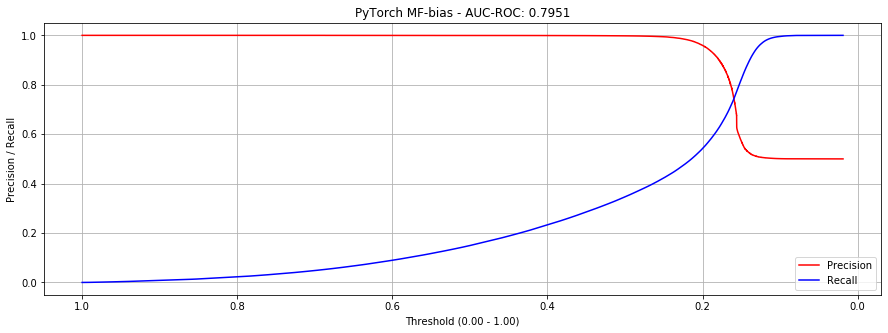

In [28]:
plot_auc(val['edge'], val['mf_bias_score'], 'PyTorch MF-bias - AUC-ROC: {:.4f}'.format(roc_score))

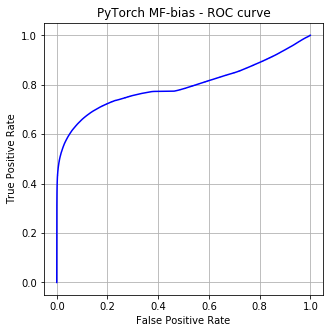

In [29]:
plot_roc(val['edge'], val['mf_bias_score'], 'PyTorch MF-bias - ROC curve')

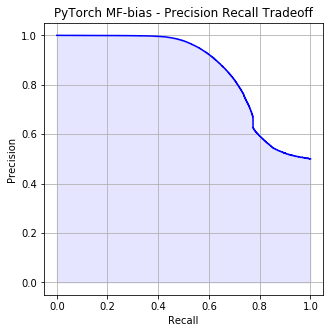

In [30]:
plot_tradeoff(val['edge'], val['mf_bias_score'], 'PyTorch MF-bias - Precision Recall Tradeoff')

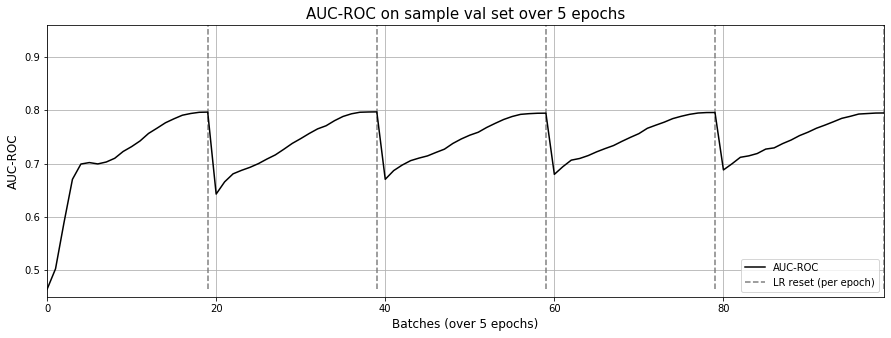

In [31]:
# Import and plot metrics
mf_bias_edge_df = pd.read_csv('../results/model_metrics_mf_bias_edges_elec.csv')
plot_metrics(mf_bias_edge_df, ylim=(0.45, 0.96))

### 4. MF (Continuous, baseline)

In [32]:
word2id_edge_mf_cont = load_model('../results/word2id_edge_mf_continuous_{}'.format(dset))
func = get_product_id(word2id_edge_mf_cont)
word2id_func = np.vectorize(func)

2019-12-19 16:35:46,002 - Model loaded from: ../results/word2id_edge_mf_continuous_elec (Size: 57402775 bytes)


In [33]:
mf = MFContinuous(len(word2id_edge_mf_cont), 128)
mf.load_state_dict(torch.load('../results/mf_continuous_edges_epoch_4_2019-12-13-0323.pt', map_location=torch.device('cpu')))

2019-12-19 16:35:46,395 - Model initialized: MFContinuous(
  (embedding): Embedding(418749, 128)
  (sig): Sigmoid()
  (mse): MSELoss()
)


<All keys matched successfully>

In [34]:
val['product1id_mf_cont_edge'] = word2id_func(val['product1'].values)
val['product2id_mf_cont_edge'] = word2id_func(val['product2'].values)

In [35]:
product1 = torch.LongTensor(val['product1id_mf_cont_edge'])
product2 = torch.LongTensor(val['product2id_mf_cont_edge'])
with torch.no_grad():
    val['mf_cont_score'] = mf.predict(product1, product2)

In [36]:
roc_score = roc_auc_score(val['edge'], val['mf_cont_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-19 16:35:55,386 - AUC-ROC: 0.933535931935834


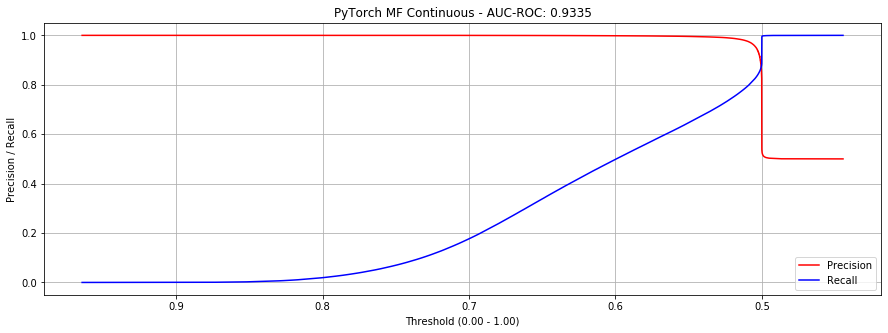

In [37]:
plot_auc(val['edge'], val['mf_cont_score'], 'PyTorch MF Continuous - AUC-ROC: {:.4f}'.format(roc_score))

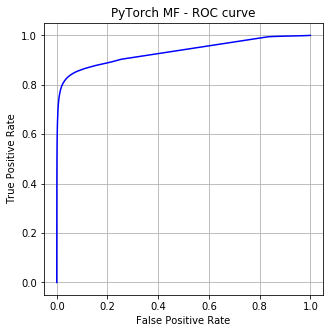

In [38]:
plot_roc(val['edge'], val['mf_cont_score'], 'PyTorch MF - ROC curve')

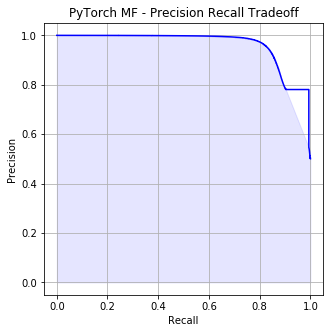

In [39]:
plot_tradeoff(val['edge'], val['mf_cont_score'], 'PyTorch MF - Precision Recall Tradeoff')

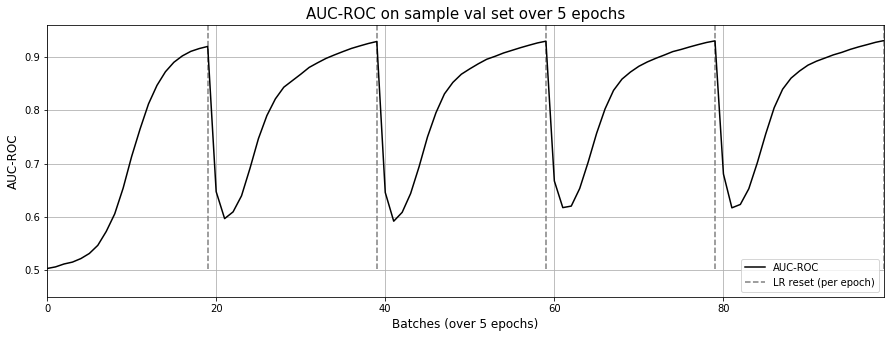

In [40]:
# Import and plot metrics
mf_edge_df = pd.read_csv('../results/model_metrics_mf_continuous_edges_elec.csv')
plot_metrics(mf_edge_df, ylim=(0.45, 0.96))

### 5. MF-bias (Continuous, baseline)

In [41]:
word2id_edge_mf_bias_cont = load_model('../results/word2id_edge_mf_bias_continuous_{}'.format(dset))
func = get_product_id(word2id_edge_mf_bias_cont)
word2id_func = np.vectorize(func)

2019-12-19 16:36:00,766 - Model loaded from: ../results/word2id_edge_mf_bias_continuous_elec (Size: 57402775 bytes)


In [42]:
mf = MFBiasContinuous(len(word2id_edge_mf_bias_cont), 128)
mf.load_state_dict(torch.load('../results/mf_bias_continuous_edges_epoch_4_2019-12-13-0427.pt', map_location=torch.device('cpu')))

2019-12-19 16:36:01,135 - Model initialized: MFBiasContinuous(
  (product_embedding): Embedding(418749, 128)
  (sig): Sigmoid()
  (product_bias): Embedding(418749, 1)
  (mse): MSELoss()
)


<All keys matched successfully>

In [43]:
val['product1id_mf_bias_cont_edge'] = word2id_func(val['product1'].values)
val['product2id_mf_bias_cont_edge'] = word2id_func(val['product2'].values)

In [44]:
product1 = torch.LongTensor(val['product1id_mf_bias_cont_edge'])
product2 = torch.LongTensor(val['product2id_mf_bias_cont_edge'])
with torch.no_grad():
    val['mf_bias_cont_score'] = mf.predict(product1, product2)

In [45]:
roc_score = roc_auc_score(val['edge'], val['mf_bias_cont_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-19 16:36:10,272 - AUC-ROC: 0.8318613515682854


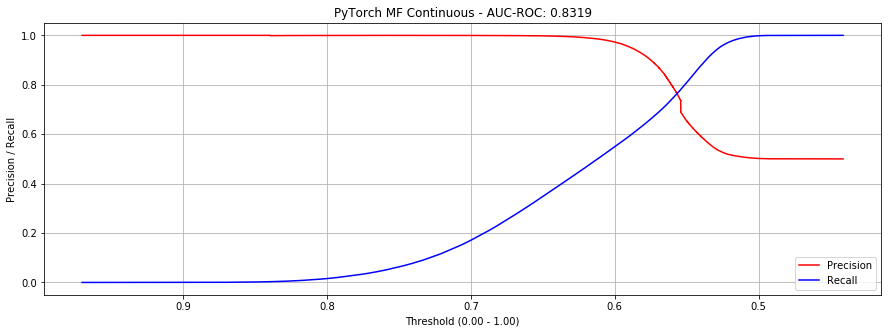

In [46]:
plot_auc(val['edge'], val['mf_bias_cont_score'], 'PyTorch MF Continuous - AUC-ROC: {:.4f}'.format(roc_score))

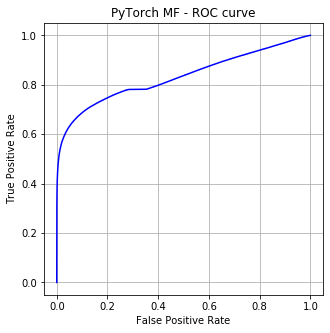

In [47]:
plot_roc(val['edge'], val['mf_bias_cont_score'], 'PyTorch MF - ROC curve')

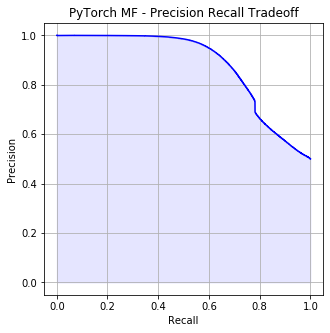

In [48]:
plot_tradeoff(val['edge'], val['mf_bias_cont_score'], 'PyTorch MF - Precision Recall Tradeoff')

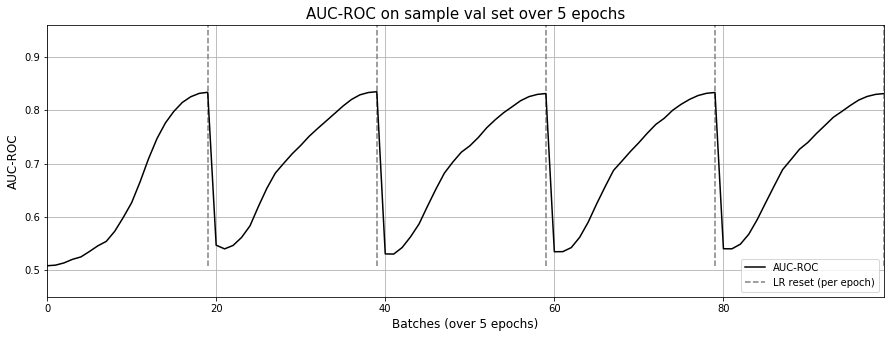

In [49]:
# Import and plot metrics
mf_bias_cont_edge_df = pd.read_csv('../results/model_metrics_mf_bias_continuous_edges_elec.csv')
plot_metrics(mf_bias_cont_edge_df, ylim=(0.45, 0.96))

### 7. Gensim word2vec (2.58 minutes)

In [50]:
# Import model
kv = KeyedVectors.load('../results/gensim-w2v-2019-12-12-0203.kv')

In [51]:
def get_kv_similarity(products):
    try:
        return kv.similarity(products[0], products[1])
    except KeyError:
        return -1
    
get_kv_sim_func = np.vectorize(get_kv_similarity)

In [52]:
val['gensim_score'] = get_kv_sim_func(val['products'].values)

In [53]:
# Set score of unseen item pairs to median score of seen item pairs
val_seen = val[val['gensim_score'] != -1]
median_score = np.median(val_seen['gensim_score'])
val['gensim_score'] = np.where(val['gensim_score'] == -1, median_score, val['gensim_score'])

In [54]:
roc_score = roc_auc_score(val['edge'], val['gensim_score'])
logger.info('AUC-ROC: {:.4f}'.format(roc_score))

2019-12-19 16:36:56,348 - AUC-ROC: 0.9082


In [55]:
roc_score_seen = roc_auc_score(val_seen['edge'], val_seen['gensim_score'])
logger.info('AUC-ROC of seen products only: {:.4f}'.format(roc_score_seen))

2019-12-19 16:36:56,970 - AUC-ROC of seen products only: 0.9735


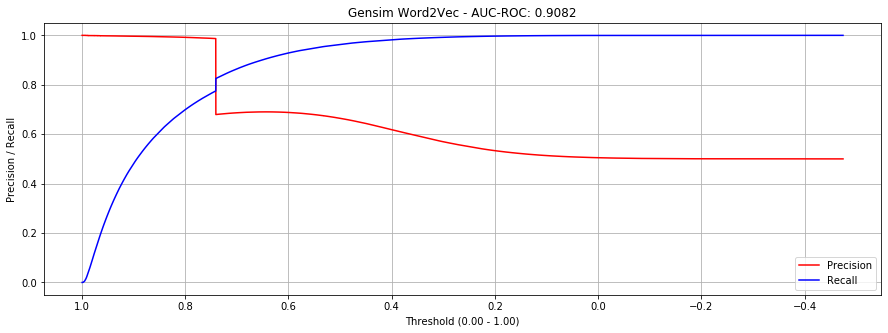

In [56]:
plot_auc(val['edge'], val['gensim_score'], 'Gensim Word2Vec - AUC-ROC: {:.4f}'.format(roc_score))

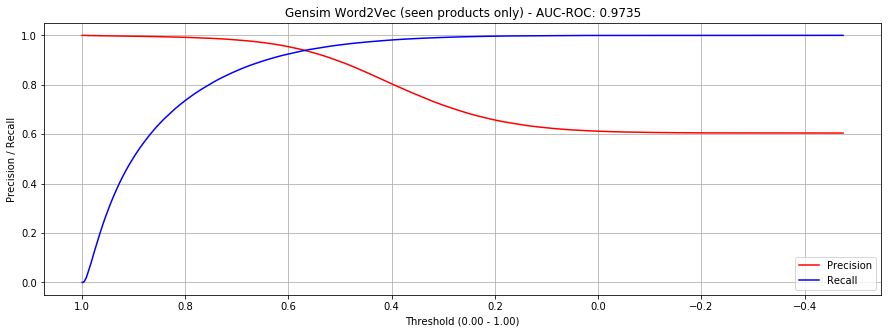

In [57]:
plot_auc(val_seen['edge'], val_seen['gensim_score'], 'Gensim Word2Vec (seen products only) - AUC-ROC: {:.4f}'.format(roc_score_seen))

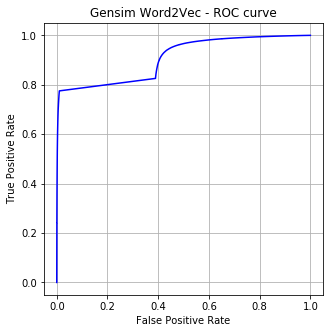

In [58]:
plot_roc(val['edge'], val['gensim_score'], 'Gensim Word2Vec - ROC curve')

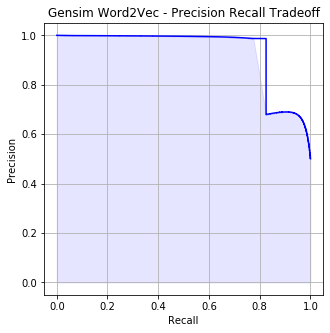

In [59]:
plot_tradeoff(val['edge'], val['gensim_score'], 'Gensim Word2Vec - Precision Recall Tradeoff')

### 8. PyTorch word2vec (23.63 minutes)

In [60]:
word2id_torch_emb = load_model('../results/word2id_torch_emb_{}'.format(dset))
func = get_product_id(word2id_torch_emb)
word2id_func = np.vectorize(func)

2019-12-19 16:37:03,862 - Model loaded from: ../results/word2id_torch_emb_elec (Size: 57402775 bytes)


In [61]:
skipgram = SkipGram(len(word2id_torch_emb), 128)
skipgram.load_state_dict(torch.load('../results/skipgram_epoch_4_2019-12-12-0648.pt', 
                                    map_location=torch.device('cpu')))

<All keys matched successfully>

In [62]:
w2v = skipgram.center_embeddings.weight.cpu().data.numpy()

In [63]:
val['product1id_w2v'] = word2id_func(val['product1'].values)
val['product2id_w2v'] = word2id_func(val['product2'].values)

In [64]:
def calculate_cosine_similarity2_vectorized(product1id, product2id):
    return np.inner(w2v[product1id], w2v[product2id]) / (np.linalg.norm(w2v[product1id]) * np.linalg.norm(w2v[product2id]))
    
cos_sim_func = np.vectorize(calculate_cosine_similarity2_vectorized)

In [65]:
val['w2v_score'] = cos_sim_func(val['product1id_w2v'].values, val['product2id_w2v'].values)

In [66]:
roc_score = roc_auc_score(val['edge'], val['w2v_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-19 16:37:43,850 - AUC-ROC: 0.9554353450075982


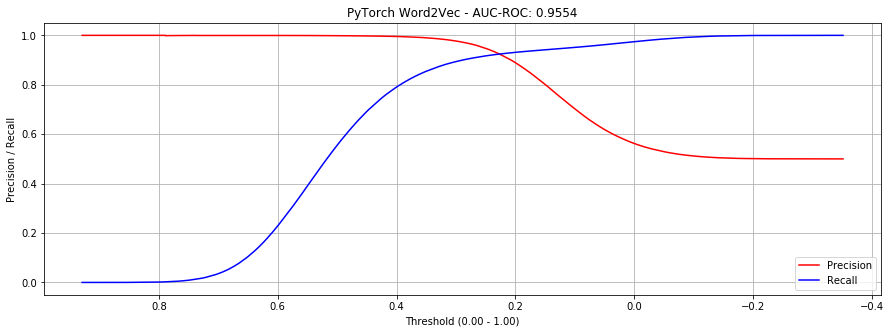

In [67]:
plot_auc(val['edge'], val['w2v_score'], 'PyTorch Word2Vec - AUC-ROC: {:.4f}'.format(roc_score))

2019-12-19 16:37:47,132 - AUC-ROC: 0.9855183441809798


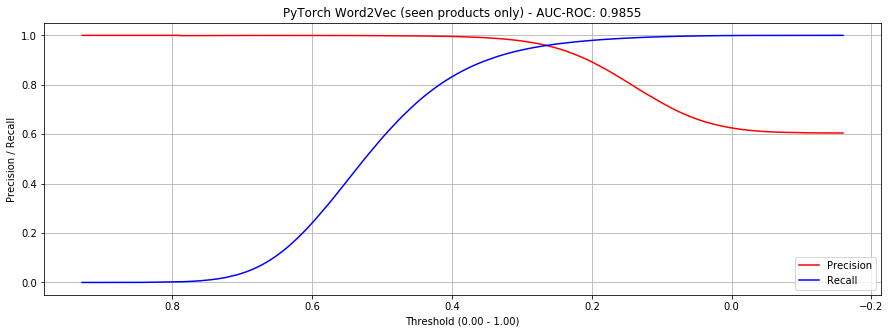

In [68]:
val_seen2 = val[val.index.isin(val_seen.index)]
roc_score_seen2 = roc_auc_score(val_seen2['edge'], val_seen2['w2v_score'])
logger.info('AUC-ROC: {}'.format(roc_score_seen2))

plot_auc(val_seen2['edge'], val_seen2['w2v_score'], 'PyTorch Word2Vec (seen products only) - AUC-ROC: {:.4f}'.format(roc_score_seen2))

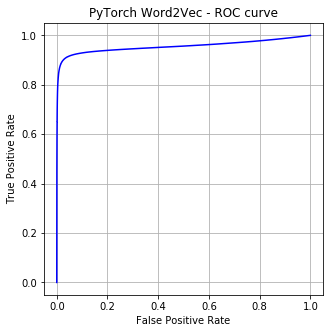

In [69]:
plot_roc(val['edge'], val['w2v_score'], 'PyTorch Word2Vec - ROC curve')

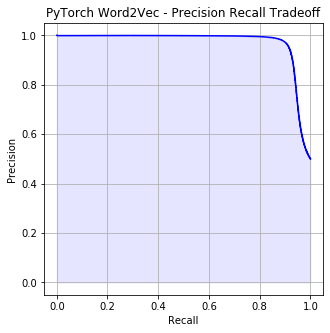

In [70]:
plot_tradeoff(val['edge'], val['w2v_score'], 'PyTorch Word2Vec - Precision Recall Tradeoff')

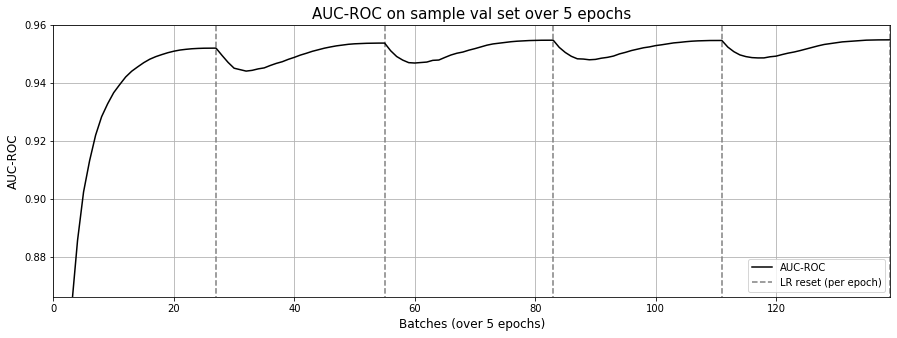

In [71]:
# Import and plot metrics
w2v_df = pd.read_csv('../results/model_metrics_w2v_elec.csv')
plot_metrics(w2v_df)

### 9. PyTorch word2vec with side information (107.66 minutes)
- Not evaluated as validation during training performed poorly

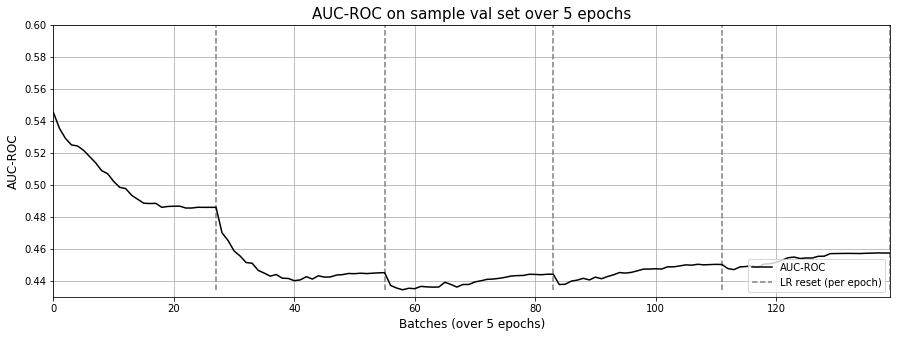

In [72]:
# Import and plot metrics
mf_bias_df = pd.read_csv('../results/model_metrics_w2v_meta_elec.csv')
plot_metrics(mf_bias_df, ylim=(0.43, 0.6))

### 10. PyTorch MF (68.5 minutes)

In [73]:
word2id_torch_mf = load_model('../results/word2id_torch_mf_{}'.format(dset))
func = get_product_id(word2id_torch_mf)
word2id_func = np.vectorize(func)

2019-12-19 16:37:53,963 - Model loaded from: ../results/word2id_torch_mf_elec (Size: 57402775 bytes)


In [74]:
mf = MF(len(word2id_torch_mf), 128)
mf.load_state_dict(torch.load('../results/mf_epoch_4_2019-12-12-0810.pt', map_location=torch.device('cpu')))

2019-12-19 16:37:54,339 - Model initialized: MF(
  (embedding): Embedding(418749, 128)
  (sig): Sigmoid()
  (bce): BCELoss()
)


<All keys matched successfully>

In [75]:
val['product1id_mf'] = word2id_func(val['product1'].values)
val['product2id_mf'] = word2id_func(val['product2'].values)

In [76]:
product1 = torch.LongTensor(val['product1id_mf'])
product2 = torch.LongTensor(val['product2id_mf'])
with torch.no_grad():
    val['mf_score'] = mf.forward(product1, product2)

In [77]:
roc_score = roc_auc_score(val['edge'], val['mf_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-19 16:38:04,607 - AUC-ROC: 0.9127203278867544


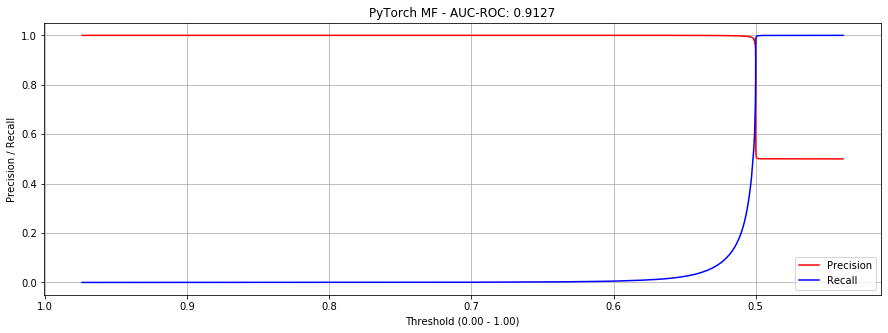

In [78]:
plot_auc(val['edge'], val['mf_score'], 'PyTorch MF - AUC-ROC: {:.4f}'.format(roc_score))

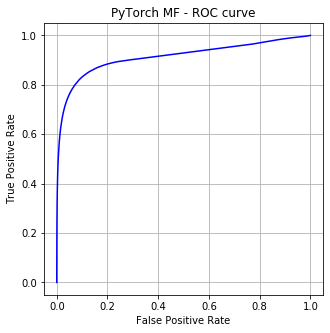

In [79]:
plot_roc(val['edge'], val['mf_score'], 'PyTorch MF - ROC curve')

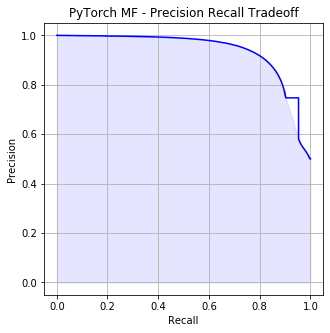

In [80]:
plot_tradeoff(val['edge'], val['mf_score'], 'PyTorch MF - Precision Recall Tradeoff')

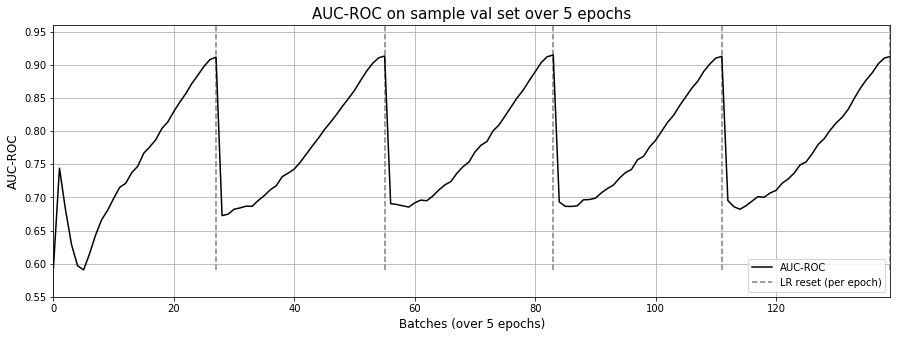

In [81]:
# Import and plot metrics
mf_df = pd.read_csv('../results/model_metrics_mf_elec.csv')
plot_metrics(mf_df, ylim=(0.55, 0.96))

### 11. PyTorch MF-bias (70.39 minutes)

In [82]:
word2id_torch_mf_bias = load_model('../results/word2id_torch_mf_bias_{}'.format(dset))
func = get_product_id(word2id_torch_mf_bias)
word2id_func = np.vectorize(func)

2019-12-19 16:38:08,698 - Model loaded from: ../results/word2id_torch_mf_bias_elec (Size: 57402775 bytes)


In [83]:
mf_bias = MFBias(len(word2id_torch_mf_bias), 128)
mf_bias.load_state_dict(torch.load('../results/mf_bias_epoch_4_2019-12-12-0942.pt', map_location=torch.device('cpu')))

2019-12-19 16:38:09,067 - Model initialized: MFBias(
  (product_embedding): Embedding(418749, 128)
  (sig): Sigmoid()
  (product_bias): Embedding(418749, 1)
  (bce): BCELoss()
)


<All keys matched successfully>

In [84]:
val['product1id_mf_bias'] = word2id_func(val['product1'].values)
val['product2id_mf_bias'] = word2id_func(val['product2'].values)

In [85]:
product1 = torch.LongTensor(val['product1id_mf_bias'])
product2 = torch.LongTensor(val['product2id_mf_bias'])
with torch.no_grad():
    val['mf_bias_score'] = mf_bias.forward(product1, product2)

In [86]:
roc_score = roc_auc_score(val['edge'], val['mf_bias_score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-19 16:38:17,305 - AUC-ROC: 0.9319550760914745


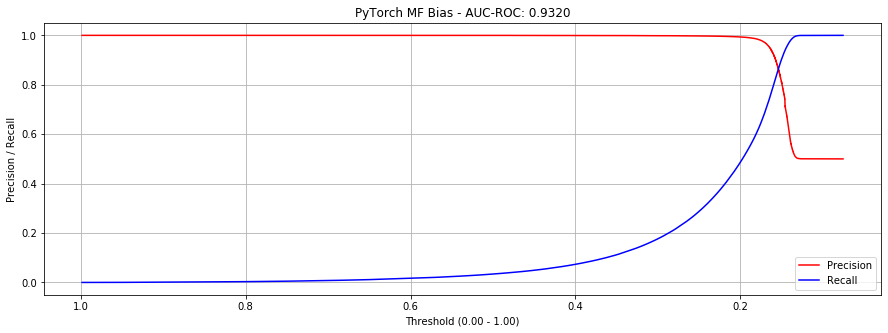

In [87]:
plot_auc(val['edge'], val['mf_bias_score'], 'PyTorch MF Bias - AUC-ROC: {:.4f}'.format(roc_score))

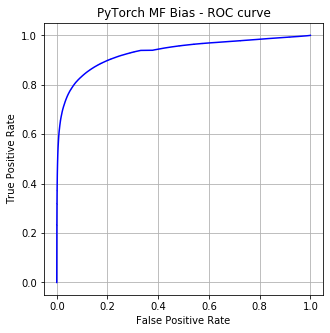

In [88]:
plot_roc(val['edge'], val['mf_bias_score'], 'PyTorch MF Bias - ROC curve')

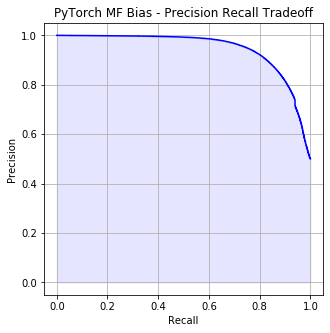

In [89]:
plot_tradeoff(val['edge'], val['mf_bias_score'], 'PyTorch MF Bias - Precision Recall Tradeoff')

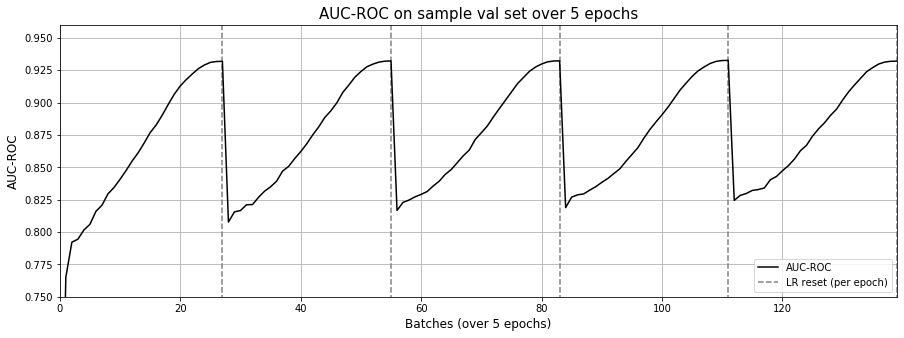

In [90]:
# Import and plot metrics
mf_bias_df = pd.read_csv('../results/model_metrics_mf_bias_elec.csv')
plot_metrics(mf_bias_df, ylim=(0.75, 0.96))

### Learning rate

In [3]:
import matplotlib.pyplot as plt
from math import pi
from math import cos
from math import floor
 
# cosine annealing learning rate schedule
def cosine_annealing(epoch, n_epochs, n_cycles, lrate_max):
	epochs_per_cycle = floor(n_epochs/n_cycles)
	cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
	return lrate_max/2 * (cos(cos_inner) + 1)

In [9]:
# create learning rate series
n_epochs = 100
n_cycles = 5
lrate_max = 0.01
series = [cosine_annealing(i, n_epochs, n_cycles, lrate_max) for i in range(n_epochs)]

Text(0.5, 1.0, 'Cosine Annealing learning rate over 5 epochs')

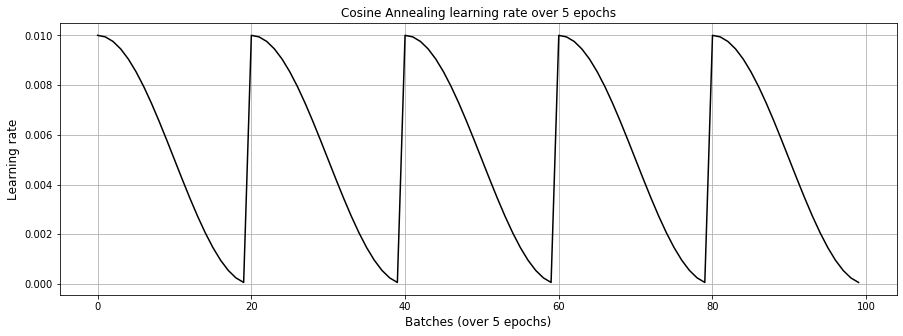

In [13]:
plt.figure(figsize=(15, 5))
plt.grid()

plt.plot(series, color='black')
plt.ylabel('Learning rate', size=12)
plt.xlabel('Batches (over 5 epochs)', size=12)
plt.title('Cosine Annealing learning rate over 5 epochs')